In [1]:
# Imports

from datetime import datetime, timedelta

from Database import db

import numpy as np
import pickle
import os

import matplotlib.pyplot as plt

from keras.optimizers import RMSprop
from keras.models import Sequential, load_model, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, concatenate, SpatialDropout1D, GRU
from keras.layers import Dense, Flatten, Embedding, LSTM, Activation, BatchNormalization, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import keras.backend as K

Using TensorFlow backend.


In [2]:
# Options

stocks      = ['AAPL', 'AMD', 'AMZN', 'GOOG', 'MSFT']
all_sources = ['reddit', 'reuters', 'twitter', 'seekingalpha']

max_length  = 50
vocab_size  = None # Set by tokenizer
emb_size    = 300

model_type  = 'regression'

epochs      = 180
batch_size  = 32

In [3]:

def make_headline_to_effect_data():
    """
    Headline -> Effect
    
    Creates essentially the X, Y data for the embedding model to use
    when analyzing/encoding headlines. Returns a list of headlines and
    a list of corresponding 'effects' which represent a change in the stock price.
    """
    meta, headlines, effects = [], [], []
    
    with db() as (conn, cur):
        
        for stock in stocks:
            
            print("Fetching Stock..." + stock)
            
            ## Go through all the headlines ##
            
            cur.execute("SELECT date, source, content FROM headlines WHERE stock=? AND LENGTH(content) >= 16", [stock])
            headline_query = cur.fetchall()
            
            for (date, source, content) in headline_query:
                
                event_date = datetime.strptime(date, '%Y-%m-%d') # The date of headline
                
                add_time = lambda e, days: (e + timedelta(days=days)).strftime('%Y-%m-%d')
                
                ## Find corresponding tick data ## 
                
                cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                            [stock, 
                             add_time(event_date, -3), 
                             add_time(event_date, 0)])
                
                before_headline_ticks = cur.fetchall()
                
                cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                            [stock, 
                             add_time(event_date, 1), 
                             add_time(event_date, 4)])
                
                after_headline_ticks = cur.fetchall()
                
                ## Create training example ##
                
                if len(before_headline_ticks) > 0 and len(after_headline_ticks) > 0:
                    
                    previous_tick = before_headline_ticks[-1][0]
                    result_tick = after_headline_ticks[0][0]
                    
                    if model_type == 'regression':
                        
                        # Percent Diff (+Normalization Constant)
                        effect = [(result_tick - previous_tick) / previous_tick / 0.022]
                    
                    else:
                
                        if result_tick > previous_tick:

                            effect = [1., 0.]

                        else:

                            effect = [0., 1.]
                        
                    meta.append((source, event_date.weekday()))
                    headlines.append(content)
                    effects.append(effect)
                    
    return meta, headlines, np.array(effects)


In [4]:

def encode_sentences(meta, sentences, tokenizer=None, max_length=100, vocab_size=100):
    """
    Encoder
    
    Takes a list of headlines and converts them into vectors
    """
    ## Encoding Sentences
    
    if not tokenizer:
        
        tokenizer = Tokenizer(num_words=vocab_size, filters='', lower=False) # Already Preprocessed
    
        tokenizer.fit_on_texts(sentences)
    
    encoded_headlines = tokenizer.texts_to_sequences(sentences)
    
    padded_headlines = pad_sequences(encoded_headlines, maxlen=max_length, padding='post')
    
    ## Encoding Meta Data
    
    # OneHot(Source [reddit/twitter/reuters etc..]) + OneHot(WeekDay)
    
    meta_matrix = np.zeros((len(sentences), len(all_sources) + 7))
    index = 0
    
    for (source, weekday) in meta:
        
        meta_matrix[index, all_sources.index(source)] = 1
        meta_matrix[index, len(all_sources) + weekday] = 1
        
        index += 1
    
    return meta_matrix, padded_headlines, tokenizer


In [5]:

def split_data(X, X2, Y, ratio):
    """
    Splits X/Y to Train/Test
    """
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    
    X  = X[indexes]
    X2 = X2[indexes]
    Y  = Y[indexes]
    
    train_size = int(len(X) * ratio)
    
    trainX,  testX  = X[:train_size],  X[train_size:]
    trainX2, testX2 = X2[:train_size], X2[train_size:]
    trainY,  testY  = Y[:train_size],  Y[train_size:]
    
    return trainX, trainX2, trainY, testX, testX2, testY


In [6]:

def get_embedding_matrix(tokenizer, pretrained_file='glove.840B.300d.txt', purge=False):
    """Load Vectors from Glove File"""
    print("Loading...WordVecs")
    
    ## Load Glove File (Super Slow) ##
    
    glove_db = dict()
    
    with open(os.path.join('..', 'data', pretrained_file), 'r', encoding="utf-8") as glove:

        for line in glove:

            values = line.split(' ')
            word = values[0].replace('-', '').lower()
            coefs = np.asarray(values[1:], dtype='float32')
            glove_db[word] = coefs

    print('Loaded Word Vectors...' + str(len(glove_db)))
    
    ## Set Embeddings ##
    
    embedding_matrix = np.zeros((vocab_size + 1, emb_size))
    
    for word, i in tokenizer.word_index.items():
        
        embedding_vector = glove_db.get(word)
        
        if embedding_vector is not None:
            
            embedding_matrix[i] = embedding_vector
            
        elif purge:
            
            with db() as (conn, cur):
                
                cur.execute("SELECT 1 FROM specialwords WHERE word=?", [word])
                
                if len(cur.fetchall()) == 0:
                    
                    print("Purge..." + word)

                    cur.execute("DELETE FROM headlines WHERE content LIKE ?", ["%" + word + "%"])
                    conn.commit()
            
    return embedding_matrix, glove_db

def correct_sign_acc(y_true, y_pred):
    """
    Accuracy of Being Positive or Negative
    """
    diff = K.equal(y_true > 0, y_pred > 0)
    
    return K.mean(diff, axis=-1)

def get_model(emb_matrix):
    
    ## Headline ##
    
    headline_input = Input(shape=(max_length,))
    
    emb = Embedding(vocab_size + 1, emb_size, input_length=max_length, weights=[emb_matrix], trainable=True)(headline_input)
    emb = SpatialDropout1D(.1)(emb)
    
    # conv = Conv1D(filters=64, kernel_size=5, padding='same', activation='selu')(emb)
    # conv = MaxPooling1D(pool_size=3)(conv)
    
    text_rnn = LSTM(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(emb)
    text_rnn = Activation('relu')(text_rnn)
    text_rnn = BatchNormalization()(text_rnn)
    
    text_rnn = LSTM(300, dropout=0.3, recurrent_dropout=0.3)(text_rnn)
    text_rnn = Activation('relu')(text_rnn)
    text_rnn = BatchNormalization()(text_rnn)
    
    ## Source ##
    
    meta_input = Input(shape=(len(all_sources) + 7,))
    
    ## Combined ##
    
    merged = concatenate([text_rnn, meta_input])
    
    final_dense = Dense(300)(merged)
    final_dense = Activation('relu')(final_dense)
    final_dense = BatchNormalization()(final_dense)
    final_dense = Dropout(0.5)(final_dense)
    
    final_dense = Dense(300)(merged)
    final_dense = Activation('relu')(final_dense)
    final_dense = BatchNormalization()(final_dense)
    final_dense = Dropout(0.5)(final_dense)
    
    if model_type == 'regression':
        
        pred_dense = Dense(1)(final_dense)
        out = pred_dense
        
        model = Model(inputs=[headline_input, meta_input], outputs=out)
    
        model.compile(optimizer=RMSprop(lr=0.001), loss='mse', metrics=[correct_sign_acc])
    
    else:
    
        pred_dense = Dense(2)(final_dense)
        out = Activation('softmax')(pred_dense)
        
        model = Model(inputs=[headline_input, meta_input], outputs=out)
    
        model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
    
    return model


In [7]:

if __name__ == "__main__":
    
    meta, headlines, effects = make_headline_to_effect_data()
    
    encoded_meta, encoded_headlines, toke = encode_sentences(meta, 
                                                             headlines, 
                                                             max_length=max_length, 
                                                             vocab_size=vocab_size)
    
    vocab_size = len(toke.word_counts)
    print("Found Words..." + str(vocab_size))
    
    emb_matrix, glove_db = get_embedding_matrix(toke)
    
    trainX, trainX2, trainY, testX, testX2, testY = split_data(encoded_headlines, encoded_meta, effects, .8)
    
    print(trainX.shape, trainX2.shape, testY.shape)


Fetching Stock...AAPL
Fetching Stock...AMD
Fetching Stock...AMZN
Fetching Stock...GOOG
Fetching Stock...MSFT
Found Words...9563
Loading...WordVecs
Loaded Word Vectors...1634534
(6750, 50) (6750, 11) (1688, 1)


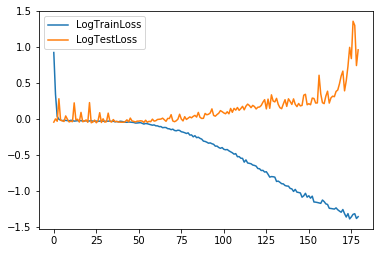

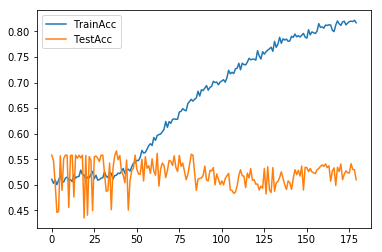

In [9]:
# TRAIN MODEL

if __name__ == "__main__":
    
    ## Save Tokenizer ##
    
    with open(os.path.join('..', 'models', 'toke.pkl'), 'wb') as toke_file:
        pickle.dump(toke, toke_file, protocol=pickle.HIGHEST_PROTOCOL)
        
    ## Create Model ##
    
    model = get_model(emb_matrix)
    
    if model_type == 'regression':
        monitor_mode = 'correct_sign_acc'
    else:
        monitor_mode = 'val_acc'
    
    tensorboard = TensorBoard(log_dir="logs/{}".format(datetime.now().strftime("%Y,%m,%d-%H,%M,%S," + model_type)))
    e_stopping = EarlyStopping(monitor=monitor_mode, patience=80)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'media-headlines-' + model_type + '.h5'), 
                                 monitor=monitor_mode,
                                 verbose=0,
                                 save_best_only=True)
    
    ## Train ##
    
    history = model.fit([trainX, trainX2],
                        trainY,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=([testX, testX2], testY),
                        verbose=0,
                        callbacks=[e_stopping, checkpoint, tensorboard])
    
    ## Display Train History ##
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['LogTrainLoss', 'LogTestLoss'])
    plt.show()
    
    plt.plot(history.history[monitor_mode])
    plt.plot(history.history['val_' + monitor_mode])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
    

In [18]:
# TEST MODEL

if __name__ == "__main__":
    
    ## Load Model For Manual Testing ##
    
    import keras.metrics
    keras.metrics.correct_sign_acc = correct_sign_acc
    
    with open(os.path.join('..', 'models', 'toke.pkl'), 'rb') as toke_file:
        toke = pickle.load(toke_file)
    
    model = load_model(os.path.join('..', 'models', 'media-headlines-' + model_type + '.h5'))
    
    ## **This Test May Overlap w/Train Data** ##
    
    current_date = '2018-02-14'
    predict_date = '2018-02-15'
    stock = 'AAPL'
    
    with db() as (conn, cur):
        
        ## Select Actual Stock Values ##
        
        cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                    [stock, current_date, predict_date])
        ticks = cur.fetchall()
        
        ## Find Headlines ##
    
        cur.execute("SELECT date, source, content FROM headlines WHERE date=? AND stock=?", [current_date, stock])
        headlines = cur.fetchall()
        
        ## Process ##
        
        meta, test_sents = [], []
        
        for (date, source, content) in headlines:
            
            meta.append([source, datetime.strptime(date, '%Y-%m-%d').weekday()])
            test_sents.append(content)
            
        encoded_meta, test_encoded, _ = encode_sentences(meta, 
                                                         test_sents, 
                                                         tokenizer=toke, 
                                                         max_length=max_length,
                                                         vocab_size=vocab_size)
        
        predictions = model.predict([test_encoded, encoded_meta])
        
        ## Display ##
        
        print("Using: " + str(test_sents))
        
        if model_type == 'regression':
            
            print("Predicting Change Coef: " +  str( round(np.mean(predictions[:, 0]), 2)))
            
        else:
        
            print("Predicting Change Coef: " +  str( round(np.mean(predictions[:, 0]) - .5, 2) * 2 ))
        
        print("Actual Stock Change: " + str( round(ticks[-1][0] - ticks[0][0], 2) ))
            

Using: ['**COMPANY**s spaceship is going to be harder to get a tour of than area', 'amazon stock climbed percent giving the company a market value of billion and topping microsofts mar', 'new **COMPANY** webpage touts apps amp technology for augmented reality on **PRODUCT**', 'heads of us law amp spy agencies say phones by **COMPANY** rival huawei pose inherent national security risk', 'qualcomm unveils gigabit lte modem amid rumors **COMPANY**s **PRODUCT** going intelonly', 'have a mac test our our mac beta because macs arent immune to malware', 'rearfacing d sensing technology possibly slated for fall **PRODUCT** allowing **COMPANY** to press ar advantage', 'if you launch something thats really different people are either going to say thats amazing or laugh in your f', '**COMPANY** expected to ship m lcd **PRODUCT** units priced at in late', 'went to **COMPANY** park and photographed it with an **PRODUCT** x of course', '**COMPANY** in talks for first order from chinese chipmaker nik

In [19]:
# TEST MODEL

if __name__ == "__main__":
    
    ## Load Model For Manual Testing ##
    
    import keras.metrics
    keras.metrics.correct_sign_acc = correct_sign_acc
     
    with open(os.path.join('..', 'models', 'toke.pkl'), 'rb') as toke_file:
        toke = pickle.load(toke_file)
    
    model = load_model(os.path.join('..', 'models', 'media-headlines-' + model_type + '.h5'))
      
    ## Fake Unique Test Data ##
    
    test_sents = [
        '**COMPANY** just released a **PRODUCT** thats better than every other company',
        '**COMPANY** just released a **PRODUCT** thats better than every other company',
        '**COMPANY** just released a **PRODUCT** thats better than every other company',
        '**COMPANY** just released a **PRODUCT** thats better than every other company'
    ]
    
    ## Process ##
    
    encoded_meta, test_encoded, _ = encode_sentences([['reuters', 0], ['twitter', 0], ['reddit', 0], ['seekingalpha', 0]], 
                                                      test_sents, 
                                                      tokenizer=toke, 
                                                      max_length=max_length, 
                                                      vocab_size=vocab_size)
    
    predictions = model.predict([test_encoded, encoded_meta])
    
    ## Display Predictions ##
    
    for i in range(len(test_sents)):
        
        print("")
        print(test_sents[i])
        print(predictions[i], "UP")



**COMPANY** just released a **PRODUCT** thats better than every other company
[ 0.7015608] UP

**COMPANY** just released a **PRODUCT** thats better than every other company
[ 1.0479691] UP

**COMPANY** just released a **PRODUCT** thats better than every other company
[ 0.71657991] UP

**COMPANY** just released a **PRODUCT** thats better than every other company
[ 0.68162] UP
